# Creating a Digit Classifier (Almost) from Scratch

In [1]:
from fastai.vision.all import *


/home/krm/mambaforge/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libc10_cuda.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


We're creating a model that can classify any images as a 3 or a 7. We'll use a sample of MNIST that contains just these.

## Data Prep

In [2]:
path = untar_data(URLs.MNIST_SAMPLE)

In [3]:
path.ls()

(#3) [Path('/home/krm/.fastai/data/mnist_sample/labels.csv'),Path('/home/krm/.fastai/data/mnist_sample/train'),Path('/home/krm/.fastai/data/mnist_sample/valid')]

The sample data is divided into training and validation sets

In [4]:
(path/"train").ls(), (path/"valid").ls()

((#2) [Path('/home/krm/.fastai/data/mnist_sample/train/7'),Path('/home/krm/.fastai/data/mnist_sample/train/3')],
 (#2) [Path('/home/krm/.fastai/data/mnist_sample/valid/7'),Path('/home/krm/.fastai/data/mnist_sample/valid/3')])

Get a list of the training set of 3s and 7s

In [5]:
threes = (path/"train"/"3").ls().sorted()
sevens = (path/"train"/"7").ls().sorted()

Have a look at one of the 3s. We use the `Image` class from PIL.

In [6]:
img3_path = threes[2]
img3 = Image.open(img3_path)
img3

We can 'see' the image as a collection of digits using numpy arrays of pytorch tensors. 

In [7]:
array(img3)[4:10, 4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,  13,  36],
       [  0,   0,   0,   0,  89, 253],
       [  0,   0,   0,   0,  89, 253],
       [  0,   0,   0,   0,  17, 151]], dtype=uint8)

In [8]:
tensor(img3)[4:10, 4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,  13,  36],
        [  0,   0,   0,   0,  89, 253],
        [  0,   0,   0,   0,  89, 253],
        [  0,   0,   0,   0,  17, 151]], dtype=torch.uint8)

Next we create tensors for each of the 3s and 7s.

In [9]:
three_tensors = [tensor(Image.open(path)) for path in threes]
seven_tensors = [tensor(Image.open(path)) for path in sevens]

In [10]:
len(three_tensors), len(seven_tensors)

(6131, 6265)

Use fastai's show_image to see a seven

<AxesSubplot: >

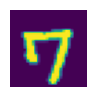

In [11]:
show_image(seven_tensors[6])

We stack each list of tensors into a single one of 3 axes (rank 3), convert to float for some operations. We also scale to values between 0 and 1 (better for the model).

In [12]:
stacked_threes = torch.stack(three_tensors).float() / 255
stacked_sevens = torch.stack(seven_tensors).float() / 255
stacked_threes.shape, stacked_sevens.shape

(torch.Size([6131, 28, 28]), torch.Size([6265, 28, 28]))

We create a training input collection by concatenating the two stacked tensors into one. We use the `view` method to reshape the tensor into two dimensions. `-1` means making the first dimension as big as possible to accomodate the new shape.

In [13]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28 * 28)

In [14]:
train_x.shape

torch.Size([12396, 784])

In [15]:
train_x[:2]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

Each item along axis 0 is now a list of 784 floats representing a single image.

We next create labels for our training input. Our objective is to classify whether an image is a 3 or not. The labels for 3s will be 1 (True) and for 7s will be 0 (False).

In [16]:
train_y_flat = tensor([1] * len(threes) + [0] * len(sevens))

In [17]:
train_y_flat.shape

torch.Size([12396])

We need to have a 2D tensor with the second dimension being a size of 1. We use pytorch's `unsqueeze` for that.

In [18]:
train_y = train_y_flat.unsqueeze(1)

In [19]:
train_y.shape

torch.Size([12396, 1])

In pytorch, a dataset needs to return a tuple of (x, y) when indexed. We therefore zip training input and labels.

In [20]:
dataset = list(zip(train_x, train_y))
x0, y0 = dataset[0]
x0.shape, y0.shape

(torch.Size([784]), torch.Size([1]))

We do the same preparation to the validation data as we've done for the training data.

In [21]:
v_threes = (path/"valid"/"3").ls().sorted()
v_sevens = (path/"valid"/"7").ls().sorted()

In [22]:
v_three_tensors = [tensor(Image.open(path)) for path in v_threes]
v_seven_tensors = [tensor(Image.open(path)) for path in v_sevens]

In [23]:
stacked_v_threes = torch.stack(v_three_tensors).float()/255
stacked_v_sevens = torch.stack(v_seven_tensors).float()/255

In [24]:
valid_x = torch.cat([stacked_v_threes, stacked_v_sevens]).view(-1, 28 * 28)

In [25]:
valid_x.shape

torch.Size([2038, 784])

In [26]:
valid_y = tensor([1] * len(v_threes) + [0] * len(v_sevens)).unsqueeze(1)
valid_y.shape

torch.Size([2038, 1])

In [27]:
validation_dataset = list(zip(valid_x, valid_y))